# Ellipse Fitting

The object defined within this notebook takes a series of X-Coords and Y-Coords and, creates a cutout shape from these and then returns a fitted equivalent ellipse.

An example of using this object can be found [at the bottom of this notebook](#Example).

No adjustment of the initial shape is done in this class, see `CutoutStraightening.ipynb` for that.

## Copyright information

Copyright © 2015 Simon Biggs

This program is free software: you can redistribute it and/or modify it under the terms of the GNU Affero General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License along with this program. If not, see http://www.gnu.org/licenses/.

## Importing modules

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline

from scipy.optimize import basinhopping

import shapely.geometry as geo
import shapely.affinity as aff

## The functions and object

In [2]:
def shapely_cutout(XCoords,YCoords):
    """Returns the shapely cutout defined by the x and y coordinates.
    """
    return geo.Polygon(np.transpose((XCoords,YCoords)))


def shapely_ellipse(ellipseRaw):
    """Given raw ellipse values create a shapely ellipse.
    """
    xPosition = ellipseRaw[0]
    yPosition = ellipseRaw[1]

    width = ellipseRaw[2]
    length = ellipseRaw[3]

    rotation = ellipseRaw[4]


    unitCircle = geo.Point(0,0).buffer(1)        
    ellipse = aff.scale(unitCircle, xfact=width/2, yfact=length/2)    # Stretched
    ellipse = aff.translate(ellipse, xoff=xPosition, yoff=yPosition)  # Translated
    ellipse = aff.rotate(ellipse, rotation)                           # Rotated

    return ellipse

In [3]:
class fit_ellipse(object):
    """An equivalent ellipse given the x and y coordinates of a cutout.
    """
    def __init__(self, n=5, debug=False, **kwargs):
        
        self.debug = debug
        
        self.cutoutXCoords = kwargs['x']
        self.cutoutYCoords = kwargs['y']
        self.cutout = shapely_cutout(self.cutoutXCoords,self.cutoutYCoords)
                
        self.basinRequiredSuccess = n
        self.ellipseRaw = self.ellipse_basinhopping()
        
        if abs(self.ellipseRaw[2]) < abs(self.ellipseRaw[3]):
            
            self.width = abs(self.ellipseRaw[2])
            self.length = abs(self.ellipseRaw[3])
            
        else:
            
            self.width = abs(self.ellipseRaw[3])
            self.length = abs(self.ellipseRaw[2])
 
            
        self.ellipse = shapely_ellipse(self.ellipseRaw)
    
    

 
    
    def minimise_function(self, ellipseRaw):
        """Returns the sum of area differences between the an ellipse and the given cutout.
        """
        ellipse = shapely_ellipse(ellipseRaw)
        
        return ellipse.difference(self.cutout).area + self.cutout.difference(ellipse).area
        
    
    def ellipse_basinhopping(self):
        """Fitting the ellipse to the cutout via scipy.optimize.basinhopping.
        """
        self.functionReturns = np.empty(self.basinRequiredSuccess)
        self.functionReturns[:] = np.nan
        
        self.numSuccess = 0
        
        minimizerConfig = {"method": 'BFGS'}
        
        initial_input = np.array([0,0,3,4,0])
        
        
        basinhoppingOutput = basinhopping(self.minimise_function,
                                          initial_input,
                                          niter=1000,
                                          minimizer_kwargs=minimizerConfig,
                                          take_step=self.step_function,
                                          callback=self.callback_function)
        
        return basinhoppingOutput.x
        
        
    def step_function(self,optimiserInput):
        """Step function used by self.ellipse_basinhopping.
        """
        optimiserInput[0] += np.random.normal(scale=1.5)   # x-position
        optimiserInput[1] += np.random.normal(scale=1.5)   # y-position
        optimiserInput[2] += np.random.normal(scale=3)     # width
        optimiserInput[3] += np.random.normal(scale=4)     # length
        optimiserInput[4] += np.random.normal(scale=90)    # rotation
        
        return optimiserInput
    
    
    def callback_function(self, optimiserOutput, minimiseFunctionOutput, minimiseAccepted):
        """Callback function used by self.ellipse_basinhopping.
        """        
        if self.debug:
            print(optimiserOutput)
            print(minimiseFunctionOutput)
            print(minimiseAccepted)
            print(" ")
        
        if minimiseAccepted:
            
            if self.numSuccess == 0:
                # First result
                self.functionReturns[0] = minimiseFunctionOutput
                self.numSuccess = 1
                
            elif minimiseFunctionOutput >= np.nanmin(self.functionReturns) + 0.0001:
                # Reject result
                0
                
            elif minimiseFunctionOutput >= np.nanmin(self.functionReturns) - 0.0001:
                # Agreeing result
                self.functionReturns[self.numSuccess] = minimiseFunctionOutput
                self.numSuccess += 1
            
            elif minimiseFunctionOutput < np.nanmin(self.functionReturns) - 0.0001:
                # New result
                self.functionReturns[0] = minimiseFunctionOutput
                self.numSuccess = 1
        
        if self.numSuccess >= self.basinRequiredSuccess:
            return True
        

## Execute no further if being imported

Don't want to waste time running the example if this notebook is just being imported. The following cell triggers the notebook import to stop.

In [4]:
'stop nbimport'

'stop nbimport'

## Example

(-1.5, 1.5, -1.5, 1.5)

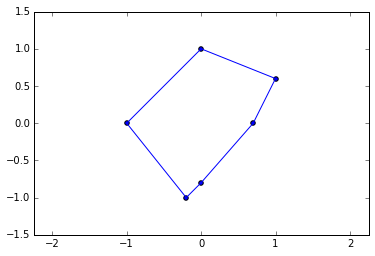

In [5]:
XCoords = [-1,-0.2,0,0.7,1,0]
YCoords = [0,-1,-.8,0,.6,1]

plt.scatter(XCoords,YCoords)
plt.plot(np.append(XCoords, XCoords[0]), 
         np.append(YCoords, YCoords[0]))
plt.axis("equal")

In [6]:
ellipse_fitting_example = fit_ellipse(x=XCoords, y=YCoords)

(-1.0, 1.0, -1.0, 1.0)

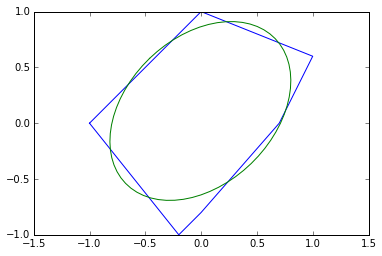

In [7]:
cutoutX = ellipse_fitting_example.cutout.exterior.xy[0]
cutoutY = ellipse_fitting_example.cutout.exterior.xy[1]
plt.plot(cutoutX, cutoutY)

ellipseX = ellipse_fitting_example.ellipse.exterior.xy[0]
ellipseY = ellipse_fitting_example.ellipse.exterior.xy[1]
plt.plot(ellipseX,ellipseY)

plt.axis("equal")